# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [53]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [54]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


**b.** Use the cell below to find the number of rows in the dataset.

In [55]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [56]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [57]:
df.groupby(df['converted']).count()

,user_id,timestamp,group,landing_page
converted,,,,
0,259241,259241,259241,259241
1,35237,35237,35237,35237


In [58]:
#proportion of users - not unique
df.query("converted == '1'").count()[0] / df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [59]:
df.query("group == 'treatment' and landing_page != 'new_page'").count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

**f.** Do any of the rows have missing values?

In [60]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [61]:
# calculating the proportion of innacuracy in the dataset
round(df.query("group == 'treatment' and landing_page != 'new_page' or group == 'control' and landing_page != 'old_page'").count()[0] / df.shape[0], 2)

0.01

Since this innacuracy only affects 0.01% of the dataset, we can removed them as they're insignificant to our analysis.

In [62]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query("group == 'treatment' and landing_page == 'new_page' or group == 'control' and landing_page == 'old_page'")

In [63]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [64]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [65]:
df2['user_id'].duplicated().sum()

1

In [66]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [67]:
df2.query("user_id == 773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [68]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(1899, inplace = True)
# Check again if the row with a duplicate user_id is deleted or not
df2.query("user_id == 773192")

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [69]:
p_pop = df2.query("converted == '1'").count()[0] / df2.shape[0]
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [70]:
c_conversion = df2.query("group == 'control' and converted == '1'").count()[0] / df2.query("group == 'control'").count()[0]
c_conversion

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [71]:
t_conversion = df2.query("group == 'treatment' and converted == '1'").count()[0] / df2.query("group == 'treatment'").count()[0]
t_conversion

0.11880806551510564

In [72]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = t_conversion - c_conversion
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [73]:
df2.query("landing_page == 'new_page'").count()[0] / df2.shape[0]

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**The treatment group/new page does not lead to more conversions in comparison to the control group/old page. However, the difference is minimal - only 0.16% smaller**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

In plain English: 
- The Null Hypothesis states the conversion rate for the new page is **less or the same** as the conversion rate for the old page
- The Alternative Hypothesis debates that the conversion rate for the new page is **more** than the conversion rate for the old page

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [74]:
print("The conversion rate for the treatment group under the null hypothesis is {}".format(round(p_pop, 4)))

The conversion rate for the treatment group under the null hypothesis is 0.1196


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [75]:
print("The conversion rate for the treatment group under the null hypothesis is {}".format(round(p_pop, 4)))

The conversion rate for the treatment group under the null hypothesis is 0.1196


The two conversion rates are the same as the population conversation as per the null hypothesis mentioned above.

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [76]:
n_new = df2.query("group == 'treatment'").count()[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [77]:
n_old = df2.query("group == 'control'").count()[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [78]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_pop), p_pop])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [79]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_pop), p_pop])
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [80]:
p_page_diff = new_page_converted.mean() - old_page_converted.mean()
p_page_diff

3.2428499414635659e-05


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [81]:
# Sampling distribution 
p_diffs = [] 
new_converted_simulation = np.random.binomial(n_new, p_pop, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_pop, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


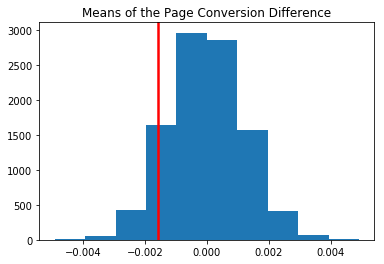

In [82]:
plt.title('Means of the Page Conversion Difference');
plt.hist(p_diffs);
plt.axvline(x = obs_diff, color = "r", linewidth = 2.5);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [83]:
#obtaining p-value

p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.90500000000000003

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**In scientific studies, this is the p-value which is the probability of observing the most extreme value in the null hypothesis in favour of the alternative hypothesis. In other words, how probable is your observed statistic to be coming from the null while still being close to the alternative. The closer the p-value is to 0.0, the less probability the observed statistic has that it came from the null thus coming from the alternative.**

>**Since the p-value is more than the alpha (0.9 > 0.05) we fail to reject the null. In other words, the conversion rate of the new page is not higher than the old page as hoped by the alternative.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [84]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("group == 'control' and converted == '1'").count()[0]

# number of conversions with the new_page
convert_new = df2.query("group == 'treatment' and converted == '1'").count()[0]

# number of individuals who were shown the old_page
n_old = df2.query("group == 'control'").count()[0]

# number of individuals who received new_page
n_new = df2.query("group == 'treatment'").count()[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.


Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [85]:
# plug in the values into the z-test model

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Our findings with the two-sample Z test show that $Z_{score}$ < $Z_{\alpha}$ (-1.31 < 0.89). Thus, we fail to reject the null. We make this assessment since the Z-score is negative and the alternative hypothesis is right-tailed alongside cross-checking the z-table to identify $Z_{\alpha}$:**

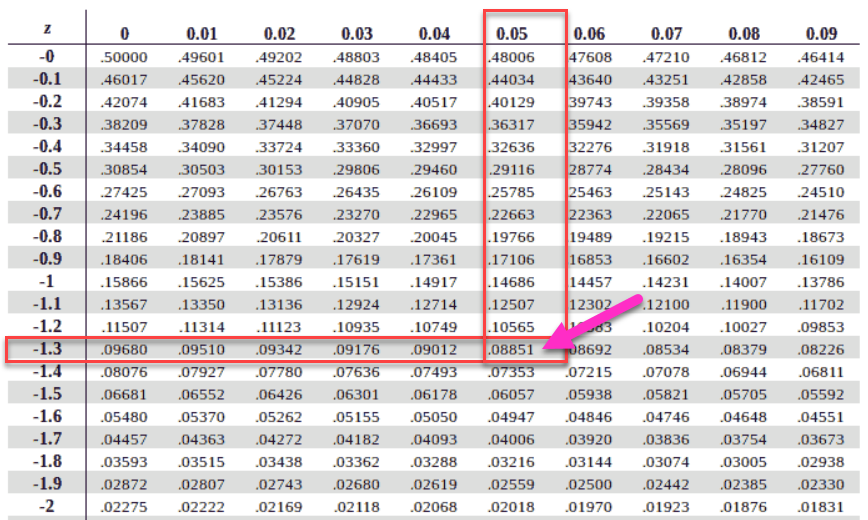


>**In terms of our p-value result obtained from the Z test, it is similar to the p-value obtained in our initial hypothesis simulation. Hence, we've failed to reject the null hypothesis twice since the p-value obtained from both tests is 0.9 which is greater than the alpha of 0.05. This means that the conversion rate of the new page is not higher than the conversion rate of the old page as assumed by the alternative hypothesis.** 

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**This business case involves predicting a binary situation based on a categorical variable (e.g 0 for no conversion, 1 for conversion) hence a logistic regression is necessary to make accurate assessments because there is a limited option of outcomes  unlike a linear regression in which there would be an infinite possiblity of outcomes.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [86]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'] #using the treatment value in group column as 1 for the new dummy column

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [87]:
# logistic regression model - lrm
#The response variable is converted whereas the independent variable is ab_page alongside intercept

#Logistic Regression Model v1

lrm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lrm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [88]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-31 13:31 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

>**The null and alternative hypotheses according to the regression model is as follows:
$$H_0: p_{new} - p_{old} = 0$$**


$$H_1: p_{new} - p_{old} \neq 0$$

In plain English: 
- The Null Hypothesis states that the conversion rate has **no change** based on the type of page
- The Alternative Hypothesis debates that the conversion rate **is different** based on the type of page

>**We are using the logistic regression model to classify change probability between the conversion rate to buy the new product and the type of page implemented rather than the increase or decrease of the conversation rate based on the type of page which is the assumption hypothesized in Part 2. Hence, the hypothesis in Part 2 is one-sided whereas in Part III it is two-sided.**

>**The p-value is 0.1899 which indicates that the association between the change of page from old to new and the conversion to buy the product is not statistically significant and fails to reject the null since it is greater than the alpha of 5%. As mentioned previously, since the hypothesis are different from Part II, the p-value are also different since we're evaluating different probabilities.**

>**Moreover, the p-value in Part III is smaller/closer to rejecting the null because the alternative needs to prove that there is a difference in conversion rate between type of pages whereas in Part II, the alternative is more scrutinized - it needs to prove that the new page has higher conversion rate rather than just an effect.** 

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**It is always good to consider other factors that might influence a conversion which can help in providing not only more statistical significance but also practical significance to our model because currently it is only taking into consideration two independent variables.**

>**Although it is usually useful to have more factors added to a model, it is also important to decide whether adding them have a practical significance to the model rather than just for the sake of adding.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [89]:
# Read the countries.csv
df_country = pd.read_csv('countries.csv')
df_country.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [90]:
#Merge the two dataframes based on user_id

df_merged = df2.set_index('user_id').join(df_country.set_index('user_id'))

In [91]:
# Create the necessary dummy variables

df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.sample(5)

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
782474,2017-01-15 17:11:49.574242,control,old_page,0,1,0,US,0,0,1
861897,2017-01-21 18:32:50.739569,treatment,new_page,1,1,1,CA,1,0,0
775629,2017-01-17 11:34:21.566965,treatment,new_page,1,1,1,US,0,0,1
694879,2017-01-13 20:58:48.155982,treatment,new_page,0,1,1,US,0,0,1
857976,2017-01-17 16:44:42.536469,treatment,new_page,0,1,1,US,0,0,1


In [92]:
#Logistic Regression Model v2

lrm2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']]) # CA as the baseline dummy variable
results = lrm2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-31 13:31 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

>**Adding the country factor adds an extra layer of impact for the new page implementation affecting the conversion. For example, the UK has a p-value of 0.0745 making it the closest variable to the alpha so far. However, it still fails to reject the null since it is higher than the alpha established.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In order to improve our model, we identified a higher order of terms that will allow for a more complext relationship between our variables of page and country. Since we want to add an interaction between these two independent variables, we will multiple them by each other:

In [93]:
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']
df_merged.sample(3)

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,,
706281,2017-01-07 00:15:10.227236,control,old_page,0,1,0,US,0,0,1,0,0
897980,2017-01-22 00:12:50.656768,control,old_page,1,1,0,US,0,0,1,0,0
821792,2017-01-18 15:15:24.480396,control,old_page,0,1,0,US,0,0,1,0,0


In [94]:
#Logistic Regression Model v3

lrm3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']]) # CA as the baseline dummy variable
results = lrm3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-31 13:31 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [95]:
# computing the reciprocal for coefficients that are negative or lower than 1
# to have a accurate interpretation of the categorical coefficient results

print(((1 / (np.exp(-0.0674))).round(2))) # ab_page
print(((np.exp(0.0314))).round(2))        # uk_ab_page
print(((np.exp(0.0469))).round(2))        # us_ab_page


1.07
1.03
1.05


## Conclusion

>**The initial logistic model only assessed that the type of page does not statistically impact the conversion rate. After improving our model with more factors, we have assessed not only the page type but also that neither the country nor the page type implemented within a country has any statistical significance on the conversion success of buying the company's product. Hence, we fail to reject the null hypothesis since all the p-values are greater than the alpha.**

>**For example, the coefficient effect for each factor is minimal (when holding all other variables constant):** 
- For every 1 new page being implemented in general, a user is *1.07* times more likely to buy the company's product
- For every 1 new page being implemented in the UK, a user is *1.03* times more likely to buy the company's product than if it was implemented in Canada
- For every 1 new page being implemented in the US, a user is *1.05* times more likely to buy the company's product than if it was implemented in Canada

>**To further elevate the interpretiation of the p-values, the factor coefficient effects are insignificant because they did not meet the significance level of 5% (different terminology for the alpha). Hence, the bullet point coefficient analysis mentioned above is irrelevant because it does not have a significant impact on the response variable, the conversion rate.** 

>**Although these results provide strong support that a new page being implemented is statistically insignifcant, we also need to consider practical significance with this A/B testing. For example, existing users might be displaying change aversion which results in skewed analysis if the time factor is not considered properly.**

>**Therefore, we will classify the timestamp column and break it down into two dummy variables like first xx days versus last xx days in order to improve the logistic regression model one step further!** 

I originally assumed the timestamp column contained multiple months with the hopes of grouping data by such however, as shown in the screenshot codes below, there is only data for January 2017. Hence the logic of breaking it down by days instead.

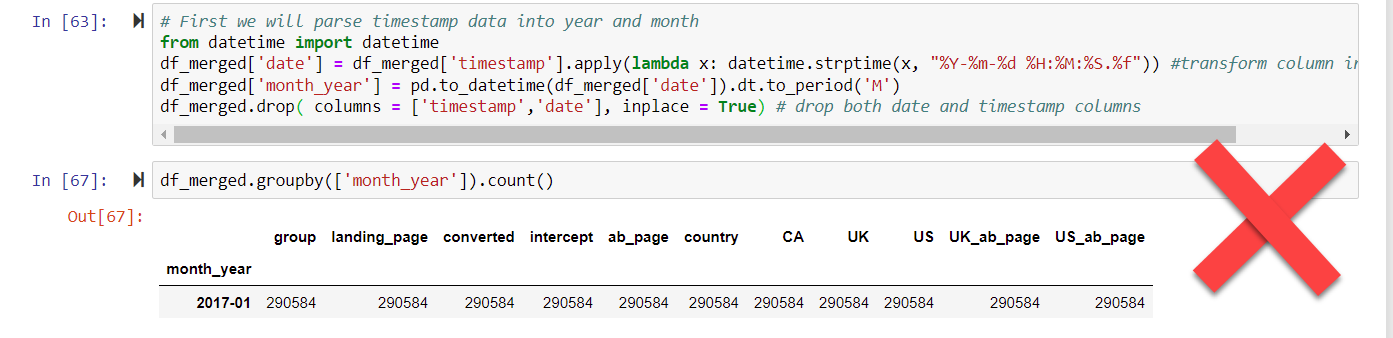

In [96]:
# First we will parse timestamp data into day
from datetime import datetime
df_merged['date'] = df_merged['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")) #transform column into datetime
df_merged['day'] = pd.to_datetime(df_merged['date']).dt.to_period('D') #reduce date to year,month and date only
df_merged.drop( columns = ['timestamp','date'], inplace = True) # drop both date and timestamp columns

In [97]:
# Then we identify how many days are recorded (output in actuality shows 24 days since it's counting from day 1 rather than day 0)
df_merged['day'].nunique()

23

We can now create a column to classify 1 as the last 12 days of new page implementation which will act as our dummy variable whereas 0 will be represented as the first 12 days and the baseline for our model (so no need to make a column for the first 12 days):

In [98]:
df_merged['day'] = df_merged['day'].values.astype(str) #convert all day values to string
df_merged['day'] = df_merged['day'].apply(lambda x: (x[len(x) - 2:])) #cut string to day digits only
df_merged['day'] = df_merged['day'].values.astype(int) #convert to int
df_merged['last_12_days'] = df_merged['day'].apply(lambda x: 1 if x > 12 else 0) #create condition column for binary column

In [99]:
# review our updated dataframe
df_merged.sample(3)

,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_ab_page,US_ab_page,day,last_12_days
user_id,,,,,,,,,,,,,
661818,control,old_page,0,1,0,UK,0,1,0,0,0,5,0
718888,control,old_page,0,1,0,US,0,0,1,0,0,11,0
780625,treatment,new_page,0,1,1,US,0,0,1,0,1,5,0


We can now plug in the new factor in the model to see whether it has an impact on the conversation rate.

In [100]:
#Logistic Regression Model v4

lrm4 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page', 'last_12_days']]) # CA as the baseline dummy variable
results = lrm4.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366107
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-31 13:31 AIC:              212783.5557
No. Observations:   290584           BIC:              212857.6132
Df Model:           6                Log-Likelihood:   -1.0638e+05
Df Residuals:       290577           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0104    0.0369  -54.4255  0.0000  -2.0828  -1.9380
ab_page       -0.0673    0.0520   -1.2935  0.1958  -0.1692   0.0347
UK             0.0118    0.0398    0.2973  0.7663  -0.0663   0.0899
US             0.0176    0.0377    0.4665  0.6408  -0.0563   0.0914
UK_ab_page     0.0782    0.0568    1.3771  0.1685  -0.0331   0.1895
US_ab_page     0.0467    0.0538    0.8686  0.3851  -0.0587   0.1521
last_12_days   0.0120    0.0115    1.0509  0.2933  -0.0104   0.0345
==================================================================

"""

Not much has changed from the previous model so we can push the model further one last time. We will add an interaction between the time factor and the type of page being implemented in each country to provide another complex relationship based on our dataset. 

One that focuses on how conversion can be impacted by not only the type of page and country where a user resides in, but also whether the number of days since the change has been implemented can make a difference:

In [101]:
df_merged['UK_page_last_12'] = df_merged['UK_ab_page'] * df_merged['last_12_days']
df_merged['US_page_last_12'] = df_merged['US_ab_page'] * df_merged['last_12_days']

#Logistic Regression Model v5

lrm5 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page', 'last_12_days', 'UK_page_last_12', 'US_page_last_12']]) # CA as the baseline dummy variable
results = lrm5.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366104
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-31 13:31 AIC:              212785.8420
No. Observations:   290584           BIC:              212881.0588
Df Model:           8                Log-Likelihood:   -1.0638e+05
Df Residuals:       290575           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept         -2.0162   0.0374 -53.9127 0.0000 -2.0895 -1.9429
ab_page           -0.0671   0.0520  -1.2907 0.1968 -0.1691  0.0348
UK                 0.0119   0.0398   0.2986 0.7652 -0.0662  0.0900
US                 0.0176   0.0377   0.4678 0.6399 -0.0562  0.0915
UK_ab_page         0.0778   0.0598   1.3007 0.1934 -0.0394  0.1950
US_ab_page         0.0631   0.0553   1.1402 0.2542 -0.0454  0.1716
last_12_days       0.0228   0.0158   1.4469 0.1479 -0.0081  0.0538
UK_page_last_12    0.0007   0.0359   0.0201 0.9839 -0.0697  0.0712
US_page_last_12   -0.0313   0.0250  -1.2521 0.2105 -0.0804  0.0177
==================================================================

"""

>**After improving the model several times with various factors and a practical understanding of the business case, we can conclude that the conversion rate is not affected by new page type implementation or by any of the other factors we observed in our models. As a result, we fail to reject the null hypothesis since none of the factors provided a p-value satisfactory to the 5% alpha so there is no statistical significance to explore.**

>**However, there is still some practical significance gained from these models which can yield stronger results in the future. The new page implementation has only been active for 24 days which is a short time for users to be properly absorbed into the page implementation experience. This means that the A/B testing performed is premature since change aversion - where existing users are comfortable with the old page and require more time to adapt to the new page - might be impacting the analysis with bias rather than actual page implementation.**

> **Therefore, if this A/B testing was performed after a longer period of time, such as 5 months, results could provide stronger statistical impact with more time data.**

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [102]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0